### spectral analysis

In [4]:
import numpy as np
import os

In [5]:
# load the data

def load_prepared_data(data_dir='/Users/akashmurali/Documents/capstone/project/capture24/preprocessed', schema='WillettsSpecific2018'):
    print(f"Loading prepared data from: {data_dir}")
    
    X = np.load(os.path.join(data_dir, 'X.npy'))
    Y = np.load(os.path.join(data_dir, f'Y_{schema}.npy'), allow_pickle=True)
    T = np.load(os.path.join(data_dir, 'T.npy'), allow_pickle=True)
    P = np.load(os.path.join(data_dir, 'P.npy'), allow_pickle=True)
    
    print(f"\nLoaded data:")
    print(f"  X shape: {X.shape}")
    print(f"  Y shape: {Y.shape}")
    print(f"  Number of participants: {len(np.unique(P))}")
    
    return X, Y, T, P


# Usage
X, Y, T, P = load_prepared_data(schema='WillettsSpecific2018')

Loading prepared data from: /Users/akashmurali/Documents/capstone/project/capture24/preprocessed

Loaded data:
  X shape: (934762, 1000, 3)
  Y shape: (934762,)
  Number of participants: 151


In [6]:
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq
from tqdm.auto import tqdm

def extract_freq_features(X, sample_rate=100, max_samples=10000):
    """Extract frequency features from windows"""
    # Use subset for quick exploration
    X_sample = X[:max_samples]
    
    features = []
    for window in tqdm(X_sample, desc="Extracting features"):
        # Calculate magnitude
        mag = np.sqrt(np.sum(window**2, axis=1))
        
        # FFT
        fft_vals = fft(mag)
        fft_freqs = fftfreq(len(mag), d=1/sample_rate)
        
        # Positive frequencies only
        pos_mask = fft_freqs > 0
        psd = np.abs(fft_vals[pos_mask]) ** 2
        freqs = fft_freqs[pos_mask]
        
        # Top 3 dominant frequencies
        top3_idx = np.argsort(psd)[-3:][::-1]
        f1, f2, f3 = freqs[top3_idx]
        p1, p2, p3 = psd[top3_idx]
        
        # Power at 0-10 Hz
        fft_bins = []
        for i in range(11):
            idx = np.argmin(np.abs(freqs - i))
            fft_bins.append(psd[idx])
        
        features.append({
            'f1': f1, 'f2': f2, 'f3': f3,
            'p1': p1, 'p2': p2, 'p3': p3,
            **{f'fft{i}': fft_bins[i] for i in range(11)}
        })
    
    return pd.DataFrame(features)

# Extract features
freq_df = extract_freq_features(X, max_samples=10000)
print(freq_df.head())

/Users/akashmurali/anaconda3/envs/har/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Extracting features: 100%|██████████| 10000/10000 [00:00<00:00, 10775.82it/s]

    f1    f2   f3        p1        p2        p3      fft0      fft1      fft2  \
0  0.2   0.4  3.7  0.590775  0.295725  0.207132  0.053695  0.028324  0.041753   
1  0.2   0.4  9.7  0.535518  0.449604  0.131199  0.065010  0.079606  0.002214   
2  0.2   0.4  8.7  0.232332  0.150710  0.134558  0.010782  0.005553  0.003386   
3  0.2  47.5  9.1  0.428171  0.096331  0.091238  0.002971  0.021680  0.003125   
4  0.2   5.3  6.0  0.427010  0.153305  0.132705  0.004632  0.029850  0.048432   

       fft3      fft4      fft5      fft6      fft7      fft8      fft9  \
0  0.181123  0.017894  0.015252  0.083918  0.012313  0.002736  0.017830   
1  0.011112  0.026193  0.010576  0.057629  0.011165  0.010394  0.027077   
2  0.020862  0.018635  0.010022  0.015542  0.001838  0.023466  0.019909   
3  0.018770  0.003776  0.036641  0.048476  0.009094  0.054933  0.007726   
4  0.030988  0.020691  0.021094  0.132705  0.025207  0.020489  0.013747   

      fft10  
0  0.005069  
1  0.023865  
2  0.002757  
3  0.0

In [7]:
# Add labels to frequency features
freq_df['activity'] = Y[:len(freq_df)]

# Remove any NaN labels
freq_df = freq_df[freq_df['activity'] != 'nan'].copy()

print("\nActivity distribution:")
print(freq_df['activity'].value_counts())

# Summary statistics by activity
summary = freq_df.groupby('activity')[['f1', 'f2', 'f3', 'p1']].agg(['mean', 'std'])
print("\nFrequency summary by activity:")
print(summary)


Activity distribution:
activity
sleep               3884
sitting             2894
household-chores     822
mixed-activity       733
walking              697
vehicle              610
standing             221
bicycling            139
Name: count, dtype: int64

Frequency summary by activity:
                        f1                    f2                    f3  \
                      mean        std       mean        std       mean   
activity                                                                 
bicycling         8.932374   5.412375   9.308633   5.768599  10.428777   
household-chores  1.661192   1.315610   1.818735   1.381587   1.922141   
mixed-activity    1.630969   1.369978   1.996317   1.983945   2.080900   
sitting           3.311057   3.985987   3.792018   4.348700   4.034831   
sleep             9.155947  10.852182  11.587745  12.202222  12.599665   
standing          3.364253   7.538268   3.955656   8.062919   3.908597   
vehicle           7.262623  11.531639   7.9

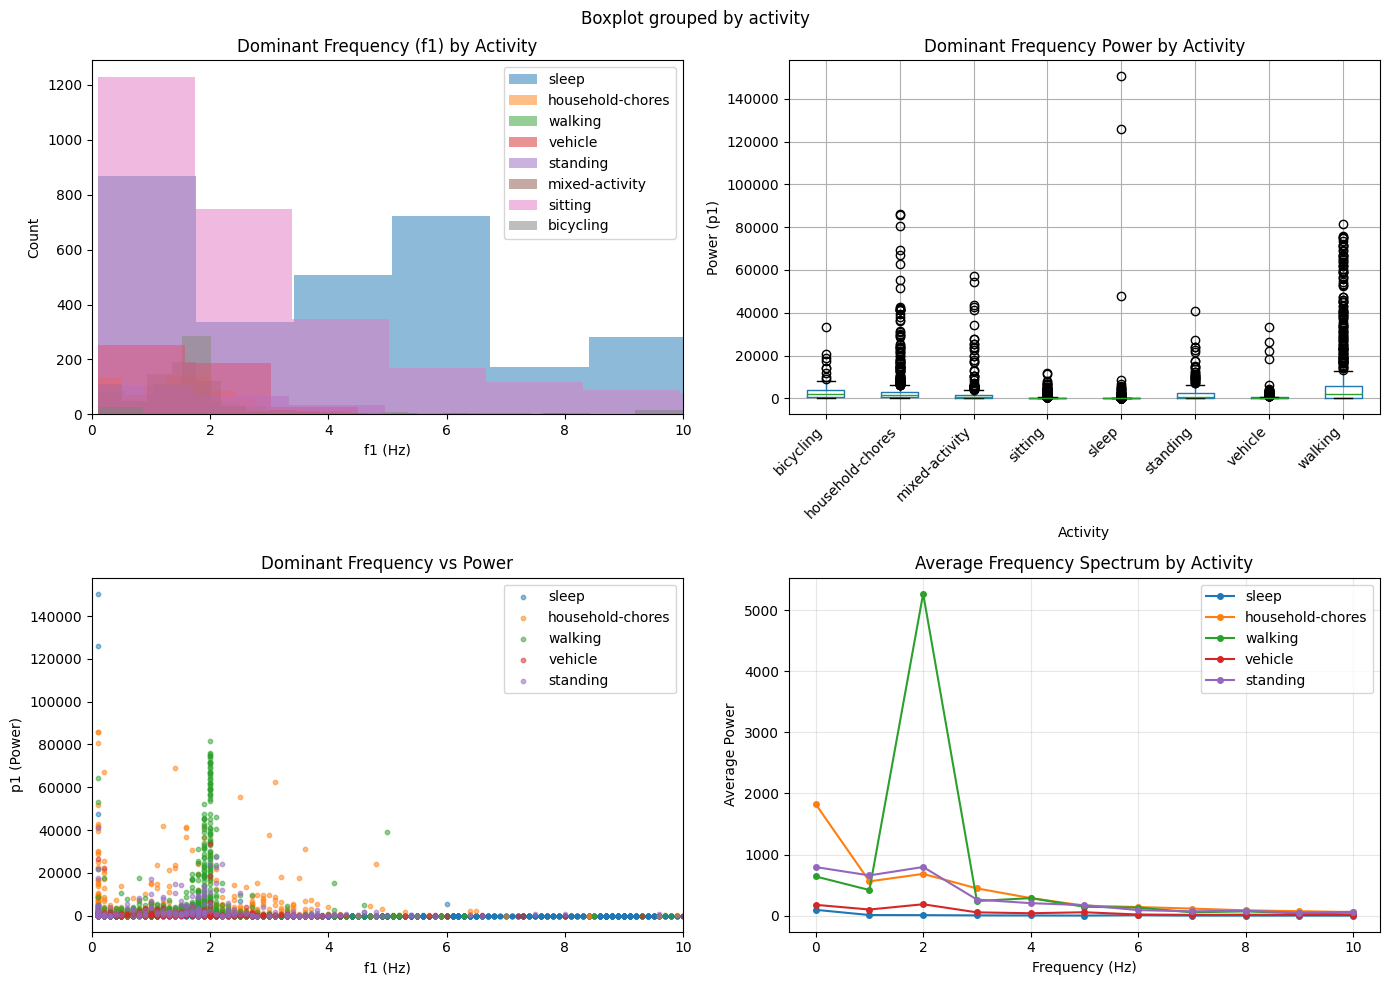

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dominant frequency by activity
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# f1 distribution
ax1 = axes[0, 0]
for activity in freq_df['activity'].unique():
    data = freq_df[freq_df['activity'] == activity]['f1']
    ax1.hist(data, alpha=0.5, label=activity, bins=30)
ax1.set_xlabel('f1 (Hz)')
ax1.set_ylabel('Count')
ax1.set_title('Dominant Frequency (f1) by Activity')
ax1.legend()
ax1.set_xlim(0, 10)

# p1 distribution  
ax2 = axes[0, 1]
freq_df.boxplot(column='p1', by='activity', ax=ax2)
ax2.set_xlabel('Activity')
ax2.set_ylabel('Power (p1)')
ax2.set_title('Dominant Frequency Power by Activity')
plt.sca(ax2)
plt.xticks(rotation=45, ha='right')

# f1 vs p1 scatter
ax3 = axes[1, 0]
for activity in freq_df['activity'].unique()[:5]:
    data = freq_df[freq_df['activity'] == activity]
    ax3.scatter(data['f1'], data['p1'], alpha=0.5, label=activity, s=10)
ax3.set_xlabel('f1 (Hz)')
ax3.set_ylabel('p1 (Power)')
ax3.set_title('Dominant Frequency vs Power')
ax3.legend()
ax3.set_xlim(0, 10)

# Average frequency spectrum per activity
ax4 = axes[1, 1]
fft_cols = [f'fft{i}' for i in range(11)]
for activity in freq_df['activity'].unique()[:5]:
    data = freq_df[freq_df['activity'] == activity][fft_cols].mean()
    ax4.plot(range(11), data.values, 'o-', label=activity, markersize=4)
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('Average Power')
ax4.set_title('Average Frequency Spectrum by Activity')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('frequency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

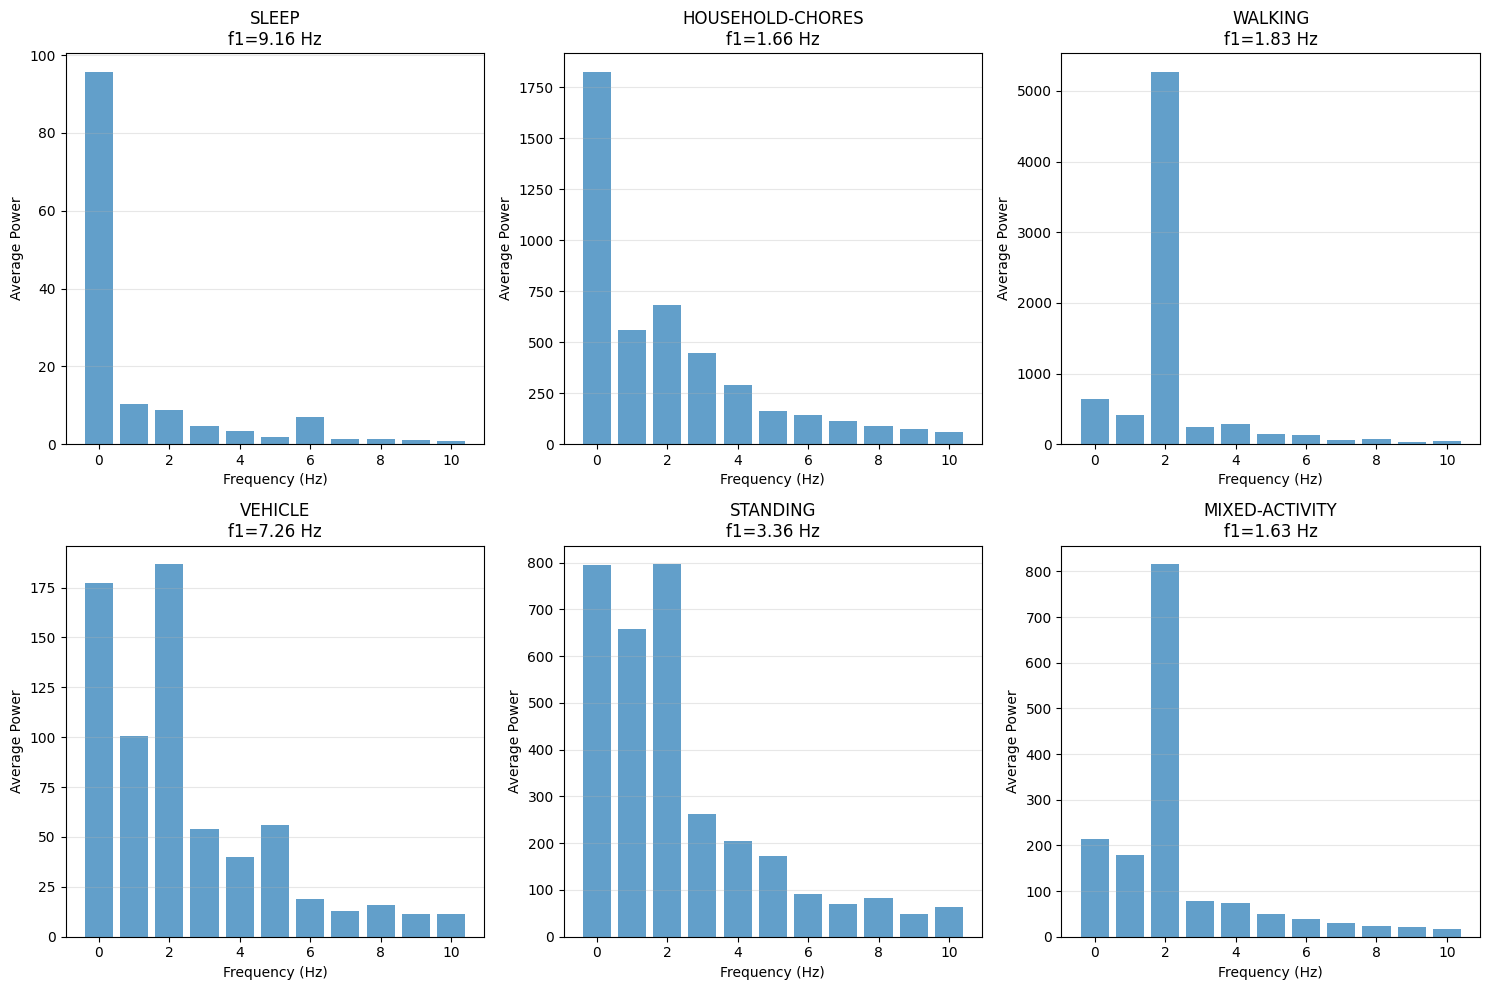

In [10]:
# Create activity signature profiles
activities = freq_df['activity'].unique()[:6]  # Top 6 activities

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, activity in enumerate(activities):
    ax = axes[idx]
    
    # Get average spectrum for this activity
    activity_data = freq_df[freq_df['activity'] == activity]
    avg_spectrum = activity_data[[f'fft{i}' for i in range(11)]].mean().values
    
    # Plot
    ax.bar(range(11), avg_spectrum, alpha=0.7)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Average Power')
    ax.set_title(f'{activity.upper()}\nf1={activity_data["f1"].mean():.2f} Hz')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('activity_signatures.png', dpi=300, bbox_inches='tight')
plt.show()